In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *
# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
#assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
#assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

alphapose_root, motionbert_root, kookmin_root, ap_kookmin_result_root

('/home/hrai/codes/AlphaPose',
 '/home/hrai/codes/MotionBERT',
 '/home/hrai/Datasets/HAAI/국민대데이터/data',
 '/home/hrai/codes/AlphaPose/examples/kookmin_result_5actions')

### Load args and Model Loading

In [44]:
os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone
from lib.model.loss import *
from lib.data.datareader_kookmin import DataReaderKOOKMIN
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_random_limb import DataReaderRandomLimb
from lib.data.dataset_motion_3d import MotionDataset3D
from lib.model.DHDSTformer import DHDSTformer, DHDSTformer2, DHDSTformer3, DHDSTformer_limb, DHDSTformer_torso

def parse_args(target):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/DHDST_kookmin_baseline.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    if target == 'MB_release':
        opts = parser.parse_args([
            '--config', 'configs/pose3d/MB_ft_h36m.yaml',
            '--evaluate', 'checkpoint/pretrain/MB_release/best_epoch.bin'])
    else:
        opts = parser.parse_args([
            '--config', 'configs/pose3d/{}.yaml'.format(target),
            '--evaluate', 'checkpoint/pose3d/{}/best_epoch.bin'.format(target)])
    return opts

# target = 'MB_release'
target = 'MB_train_h36m'
# target = 'MB_ft_h36m'
# target = 'FT_MB_release_MB_ft_h36m'
# target = 'MB_ft_h36m_with_canonical2'
# target = 'DHDST2_kookmin_baseline'
# target = 'DHDST2_h36m_baseline'
# target = 'DHDST_limb_h36m_baseline'
# target = 'DHDST_torso_h36m_baseline'
# target = 'DHDST_torso_h36m_lower1_upper1'
# target = 'MB_limb_train_h36m_random_limb_baseline'

# lower_upper_loss = False
# lambda_lower = 0
# lambda_upper = 0
# if lower_upper_loss:
#     if lambda_lower == 0.0:
#         target = 'DHDST_torso_h36m_upper{}'.format(lambda_upper)
#     elif lambda_upper == 0.0:
#         target = 'DHDST_torso_h36m_lower{}'.format(lambda_lower)
#     else:
#         target = 'DHDST_torso_h36m_lower{}_upper{}'.format(lambda_lower, lambda_upper)
# else:
#     target = 'DHDST_torso_h36m_baseline'

opts = parse_args(target=target)
args = get_config(opts.config)
print(opts.evaluate)

if 'DHDST2' in opts.evaluate:
    model_pos = DHDSTformer2(chk_filename='', args=args)
elif 'DHDST_torso' in opts.evaluate:
    model_pos = DHDSTformer_torso(chk_filename='', args=args)
elif 'DHDST_limb' in opts.evaluate:
    model_pos = DHDSTformer_limb(chk_filename='', args=args)
elif 'MB' in opts.evaluate:
    model_pos = load_backbone(args)
    
model_pos = nn.DataParallel(model_pos)
model_pos = model_pos.cuda()
checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos.eval()

checkpoint/pose3d/MB_train_h36m/best_epoch.bin


DataParallel(
  (module): DSTformer(
    (joints_embed): Linear(in_features=3, out_features=512, bias=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks_st): ModuleList(
      (0): Block(
        (norm1_s): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (norm1_t): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (attn_s): Attention(
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (attn_t): Attention(
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2_s): LayerNorm((512,), eps=1e-06,

### Data Loading (squat_test, squat_test_front)

num video frames : 270
image size : 1920 1080
270


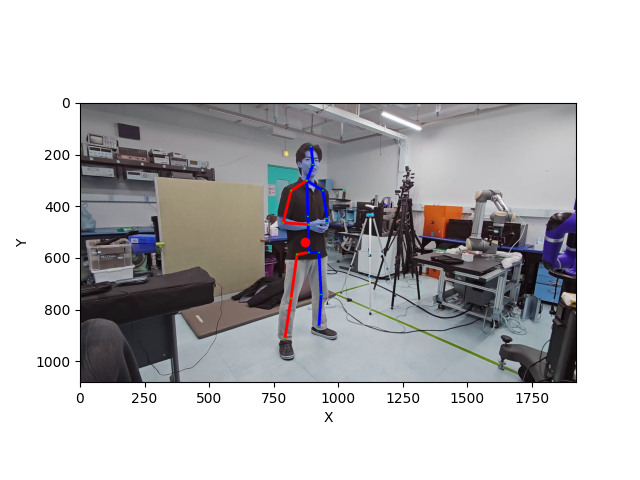

In [47]:
# custom ap result
ap_root = '/home/hrai/codes/AlphaPose/examples'
target_video = 'squat_test'
ap_result_path = os.path.join(ap_root, target_video)
video_path = os.path.join(ap_root, target_video + '.mp4')
W, H, video_num_frames, fps = get_video_info(video_path)


pose_2d_list = get_ap_pose_2d(video_path, ap_result_path)
print('num video frames :', video_num_frames)
print('image size :', W, H)
print(len(pose_2d_list))

# Check 2D pose
frame_num = 0
frame_img = get_video_frame(video_path, frame_num)
cx, cy, w, h = change_bbox_convention(get_bbox_from_pose2d(pose_2d_list[frame_num]), input_type='xyxy', output_type='xywh')
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig, W=W, H=H)
img = get_2d_pose_image(pose_2d_list[frame_num], img=frame_img, W=W, H=H)
ax.imshow(img)
ax.plot(cx, cy, 'ro')
plt.show()

In [5]:
# get aligned 2d pose
kookmin_setting = read_pkl('/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting/S01_5_squat_001.pkl')
joint_2d_src = pose_2d_list[:, :, :2].copy()
joint_2d_tar = np.array(kookmin_setting['joint_2d'])
print(joint_2d_src.shape, joint_2d_tar.shape)

root_joint = 0
src_trans = joint_2d_src[:, root_joint].mean(axis=0)
tar_trans = joint_2d_tar[:, root_joint].mean(axis=0)

height_src = joint_2d_src[:, :, 1].mean(axis=0).max() - joint_2d_src[:, :, 1].mean(axis=0).min()
height_tar = joint_2d_tar[:, :, 1].mean(axis=0).max() - joint_2d_tar[:, :, 1].mean(axis=0).min()
ratio = height_tar / height_src

pose_2d_list_aligned = pose_2d_list.copy()
pose_2d_list_aligned[:, :, :2] = (joint_2d_src - src_trans)*ratio + src_trans

frame_num = 65
frame_img = get_video_frame(video_path, frame_num)
fig = plt.figure(100)
fig.clear()
ax = axes_2d(fig, W=W, H=H)
img = get_2d_pose_image(pose_2d_list[frame_num], img=frame_img, W=W, H=H)
img = get_2d_pose_image(pose_2d_list_aligned[frame_num], img=img, W=W, H=H)
ax.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting/S01_5_squat_001.pkl'

### Inference

In [48]:
args.flip = False
input_type = 'video' # 'video' or 'frame'
if input_type == 'video':
    start_frame = 0
    assert start_frame + 243 < len(pose_2d_list), "start_frame + 243 should be less than the size of pose_2d_list"
    input_data = pose_2d_list[start_frame:start_frame+243].copy() # 243 frames # [243, 17, 3]
elif input_type == 'frame':
    frame_num = 50
    input_data = np.repeat(pose_2d_list[50].copy().reshape(-1, 17, 3), repeats=243, axis=0) # 1 frame
input_data = normalize_input(input_data, W, H) # normalize
input_data = torch.Tensor(input_data).unsqueeze(0) # to batch tensor
if 'canonical' in target:
    input_data_canonical = input_data.detach().clone()
    input_data_canonical = input_data_canonical - input_data_canonical[:, :, 0:1, :]
if 'DHDST' in target:
    output = get_inference_from_dhdst(model_pos, input_data, args, W, H)[0]
elif 'MB' in target:
    if 'canonical' in target:
        output = get_inference_from_motionbert(model_pos, input_data_canonical, args, W, H)[0]
    else:
        output = get_inference_from_motionbert(model_pos, input_data, args, W, H)[0]
print(target, output.shape)

MB_train_h36m (243, 17, 3)


In [30]:
t1 = input_data - input_data[:, :, 0].unsqueeze(2).repeat(1, 1, 17, 1)
t2 = input_data - input_data[:, :, 0:1, :]
t1.shape, t2.shape, (t1-t2).abs().max()

(torch.Size([1, 243, 17, 3]), torch.Size([1, 243, 17, 3]), tensor(0.))

In [32]:
'_'.join([opts.evaluate.split('/')[2], target_video, input_type]) + '.mp4'

'FT_MB_release_MB_ft_h36m_squat_test_video.mp4'

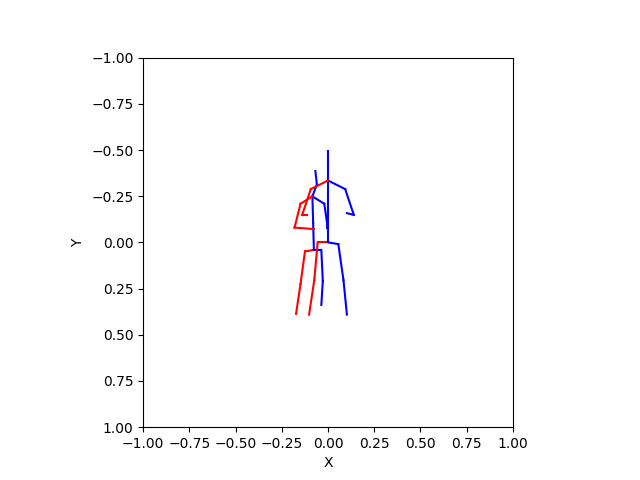

In [39]:
fig = plt.figure(1)
fig.clear()
ax = axes_2d(fig, normalize=True)
draw_2d_pose(ax, input_data[0, 0].detach().cpu().numpy(), normalize=True)
draw_2d_pose(ax, input_data_canonical[0, 0].detach().cpu().numpy(), normalize=True)
plt.show()

### Save Output Video

In [49]:
# save output video
video_folder = os.path.join('output_videos', target_video)
if not os.path.isdir(video_folder):
    os.makedirs(video_folder)
video_path = os.path.join(video_folder, '_'.join([opts.evaluate.split('/')[2], target_video, input_type]) + '.mp4')
print(video_path)
save_h36m_pose_video(output, video_path, cam_space=True, on_ground=True, refine_tilt=False, dynamic_view=True)

output_videos/squat_test/MB_train_h36m_squat_test_video.mp4


100%|██████████| 243/243 [00:05<00:00, 47.46it/s]


(17, 3)


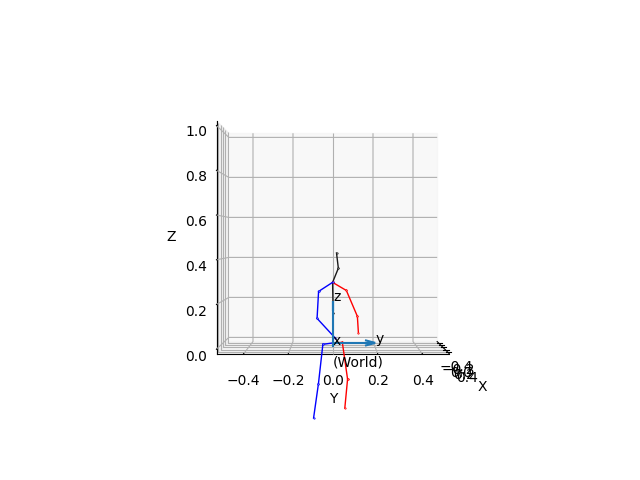

In [9]:
# check output (1 frame)
pose = get_rootrel_pose(output[0].copy()) # 1 frame
#pose = get_rootrel_pose(output[0].copy()) # 1 frame
print(pose.shape)
R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
pose = rotate_torso_by_R(pose, R2 @ R1)
l_ankle = pose[get_h36m_keypoint_index('L_Ankle')]
r_ankle = pose[get_h36m_keypoint_index('R_Ankle')]
c_ankle = (l_ankle + r_ankle) / 2
#pose -= c_ankle
head = pose[get_h36m_keypoint_index('Head')]
tilt = degrees(np.arctan2(head[2] - c_ankle[2], head[0] - c_ankle[0])) - 90
R3 = Rotation.from_rotvec([0, np.radians(tilt), 0]).as_matrix() # tilt around y-axis
#pose = rotate_torso_by_R(pose, R3)


fig = plt.figure(5)
fig.clear()
ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1))
draw_3d_pose(ax, pose)
generate_world_frame().draw3d(scale=0.2, head_length=0.05)
plt.show()

### Data Loading (h36m)

In [3]:
args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'
args.subset_list = ['H36M-SH']
datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)


In [4]:
loss = 0
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader):
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
            batch_gt = batch_gt.cuda()
        batch_gt_torso = batch_gt[:, :, [0, 1, 4, 7, 8, 9, 10, 11, 14], :] 
        if 'canonical' in target:
            batch_input_canonical = batch_input.detach().clone()
            batch_input_canonical = batch_input_canonical - batch_input_canonical[:, :, 0:1, :]
            batch_gt_canonical = batch_gt.detach().clone()
            batch_gt_canonical = batch_gt_canonical - batch_gt_canonical[:, :, 0:1, :]
    
        if 'DHDST2' in opts.evaluate:
            batch_output = model_pos(batch_input)
        elif 'DHDST_torso' in opts.evaluate:
            batch_torso_output, batch_lower_frame_R, batch_upper_frame_R  = model_pos(batch_input)
        elif 'DHDST_limb' in opts.evaluate:
            batch_output = model_pos(batch_input, batch_gt_torso)
        elif 'MB' in opts.evaluate:
            if 'canonical' in target:
                batch_output = model_pos(batch_input_canonical)
            else:
                batch_output = model_pos(batch_input)

        # limb length loss
        if 'DHDST_torso' not in opts.evaluate:
            batch_gt_length = get_limb_lens(batch_gt) # [B, N, 16]
            batch_pred_length = get_limb_lens(batch_output) # [B, N, 16]
            batch_gt_limb_length = batch_gt_length[:, :, [1, 2, 4, 5, 11, 12, 14, 15]]
            batch_pred_limb_length = batch_pred_length[:, :, [1, 2, 4, 5, 11, 12, 14, 15]]
            loss += nn.L1Loss()(batch_gt_limb_length, batch_pred_limb_length)
        break
loss /= len(test_loader)
loss

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:02<?, ?it/s]


tensor(1.8880e-05, device='cuda:0')

0.14386776 0.15138616
0.110257745 0.120970376
(17, 3)
(17, 3)


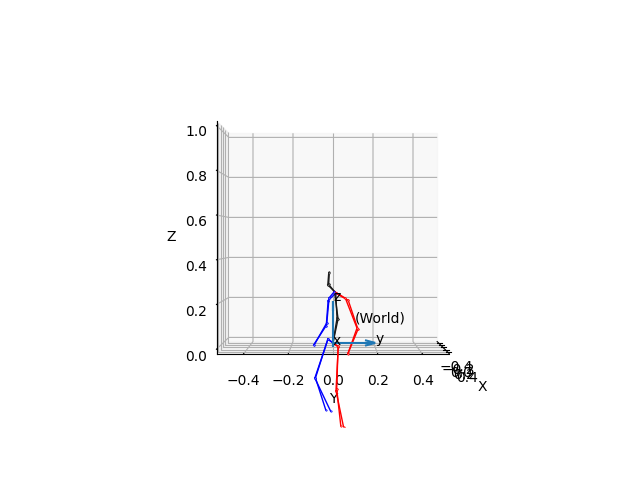

In [6]:
# check output (1 frame)
batch_num = 6
frame_num = 50

gt_pose = batch_gt_canonical[batch_num, frame_num].cpu().numpy()
pred_pose = batch_output[batch_num, frame_num].cpu().numpy()

gt_length = batch_gt_length[batch_num, frame_num].cpu().numpy()
pred_length = batch_pred_length[batch_num, frame_num].cpu().numpy()

gt_limb_length = batch_gt_limb_length[batch_num, frame_num].cpu().numpy()
pred_limb_length = batch_pred_limb_length[batch_num, frame_num].cpu().numpy()

gt_right_upper_leg_length = gt_limb_length[0]
gt_right_under_leg_length = gt_limb_length[1]
gt_left_upper_leg_length  = gt_limb_length[2]
gt_left_under_leg_length  = gt_limb_length[3]
gt_left_upper_arm_length  = gt_limb_length[4]
gt_left_under_arm_length  = gt_limb_length[5]
gt_right_upper_arm_length = gt_limb_length[6]
gt_right_under_arm_length = gt_limb_length[7]

pred_right_upper_leg_length = pred_limb_length[0]
pred_right_under_leg_length = pred_limb_length[1]
pred_left_upper_leg_length  = pred_limb_length[2]
pred_left_under_leg_length  = pred_limb_length[3]
pred_left_upper_arm_length  = pred_limb_length[4]
pred_left_under_arm_length  = pred_limb_length[5]
pred_right_upper_arm_length = pred_limb_length[6]
pred_right_under_arm_length = pred_limb_length[7]

print(gt_right_upper_arm_length, pred_right_upper_arm_length)
print(gt_right_under_arm_length, pred_right_under_arm_length)


def postprocessing(pose):
    #pose = get_rootrel_pose(output[0].copy()) # 1 frame
    print(pose.shape)
    R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
    R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
    pose = rotate_torso_by_R(pose, R2 @ R1)
    l_ankle = pose[get_h36m_keypoint_index('L_Ankle')]
    r_ankle = pose[get_h36m_keypoint_index('R_Ankle')]
    c_ankle = (l_ankle + r_ankle) / 2
    #pose -= c_ankle
    head = pose[get_h36m_keypoint_index('Head')]
    tilt = degrees(np.arctan2(head[2] - c_ankle[2], head[0] - c_ankle[0])) - 90
    R3 = Rotation.from_rotvec([0, np.radians(tilt), 0]).as_matrix() # tilt around y-axis
    #pose = rotate_torso_by_R(pose, R3)
    return pose

gt_pose = postprocessing(gt_pose)
pred_pose = postprocessing(pred_pose)

%matplotlib widget
fig = plt.figure(5)
fig.clear()
ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1))
draw_3d_pose(ax, gt_pose)
draw_3d_pose(ax, pred_pose)
generate_world_frame().draw3d(scale=0.2, head_length=0.05)
plt.show()

### Data Loading (kookmin test)

### Data Loading (random limb)

In [5]:
args.dt_file = 'random_limb_train1600_test400.pkl'
args.subset_list = ['RANDOM_LIMB_TRAIN1600_TEST400']
datareader = DataReaderRandomLimb(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)


In [8]:
loss = 0
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader):
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
            batch_gt = batch_gt.cuda()
        batch_output = model_pos(batch_input)
        # if 'DHDST2' in opts.evaluate:
        #     batch_output = model_pos(batch_input)
        # elif 'DHDST_torso' in opts.evaluate:
        #     batch_torso_output, batch_lower_frame_R, batch_upper_frame_R  = model_pos(batch_input)
        # elif 'DHDST_limb' in opts.evaluate:
        #     batch_output = model_pos(batch_input, batch_gt_torso)
        # elif 'MB' in opts.evaluate:
        #     batch_output = model_pos(batch_input)
        break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]


(3, 3)
(3, 3)


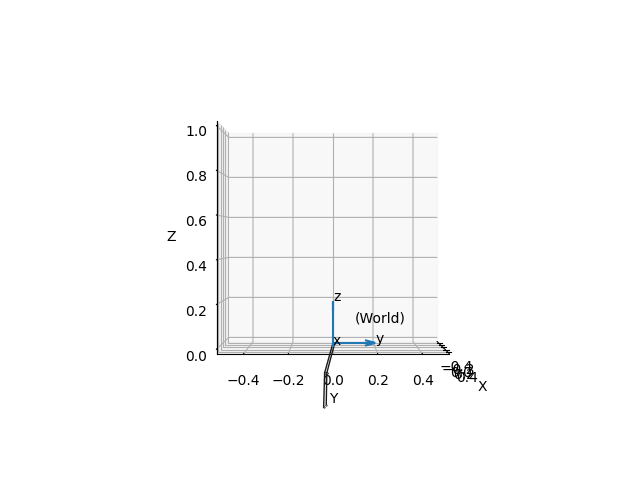

In [22]:
# check output (1 frame)
batch_num = 10
frame_num = 179

gt_pose = batch_gt[batch_num, frame_num].cpu().numpy()
pred_pose = batch_output[batch_num, frame_num].cpu().numpy()

def postprocessing(pose):
    #pose = get_rootrel_pose(output[0].copy()) # 1 frame
    print(pose.shape)
    R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
    R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
    pose = rotate_torso_by_R(pose, R2 @ R1)
    return pose

gt_pose = postprocessing(gt_pose)
pred_pose = postprocessing(pred_pose)
gt_pose_hat = gt_pose - gt_pose[0]

fig = plt.figure(5)
fig.clear()
ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1))
#draw_3d_pose(ax, gt_pose, dataset='limb')
draw_3d_pose(ax, gt_pose_hat, dataset='limb')
draw_3d_pose(ax, pred_pose, dataset='limb')
generate_world_frame().draw3d(scale=0.2, head_length=0.05)
plt.show()

### Results for kookmin squat (대각선 방향)

### Compare limb length result

In [ ]:
# _, split_id_test = datareader.get_split_id()
# actions = np.array(datareader.dt_dataset['test']['action']) # 103130 ['squat' ...  'kneeup']
# factors = np.array(datareader.dt_dataset['test']['2.5d_factor']) # 103130 [3.49990559 ... 2.09230852]
# gts = np.array(datareader.dt_dataset['test']['joints_2.5d_image']) # 103130, 17, 3
# sources = np.array(datareader.dt_dataset['test']['source']) # 103130 ['S02_6_squat_001' ... 'S08_4_kneeup_001']

# num_test_frames = len(actions)
# frames = np.array(range(num_test_frames))
# action_clips = np.array([actions[split_id_test[i]] for i in range(len(split_id_test))]) # actions[split_id_test]
# factor_clips = np.array([factors[split_id_test[i]] for i in range(len(split_id_test))]) # factors[split_id_test]
# source_clips = np.array([sources[split_id_test[i]] for i in range(len(split_id_test))]) # sources[split_id_test]
# frame_clips  = np.array([frames[split_id_test[i]] for i in range(len(split_id_test))]) # frames[split_id_test]
# gt_clips     = np.array([gts[split_id_test[i]] for i in range(len(split_id_test))]) # gts[split_id_test]

In [13]:
# split_id_test[idx], action_clips[idx], factor_clips[idx], source_clips[idx], frame_clips[idx], gt_clips[idx].shape

In [21]:
# for frame in range(0, len(gt_clips[idx]), 50):
#     print(factor_clips[idx][frame])
#     pose_3d_pred = results_all[idx][frame] * 3.7#factor_clips[idx][frame]
#     pose_3d_gt = gt_clips[idx][frame]
#     pose_3d_pred -= pose_3d_pred[0]
#     pose_3d_gt -= pose_3d_gt[0]
#     fig = plt.figure(0)
#     fig.clear()
#     ax = axes_3d(fig)
#     draw_3d_pose(ax, pose_3d_pred/1000.0)
#     draw_3d_pose(ax, pose_3d_gt/1000.0)
#     #plt.show()
#     plt.savefig('test{}.png'.format(frame))
#     #break
    

3.499905586242676
3.5017988681793213
3.500577449798584
3.495361566543579
3.4970390796661377


In [16]:
h36m_connections = [
    (0,1),   # pelvis - r_hip
    (0,4),   # pelvis - l_hip
    (0,7),   # pelvis - torso
    (1,2),   # r_hip - r_knee
    (2,3),   # r_knee - r_ankle
    (4,5),   # l_hip - l_knee
    (5,6),   # l_knee - l_ankle
    (7,8),   # torso - neck
    (8,9),   # neck - nose
    (9,10),  # nose - headtop
    (8,14),  # neck - r_shoulder
    (14,15), # r_shoulder - r_elbow
    (15,16), # r_elbow - r_wrist
    (8,11),  # neck - l_shoulder
    (11,12), # l_shoulder - l_elbow
    (12,13)  # l_elbow - l_wrist
]

def get_link_length(pose_3d, connections):
    # pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
    # r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
    # l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
    link_length = []
    for connection in connections:
        link_length.append(np.linalg.norm(pose_3d[connection[0]] - pose_3d[connection[1]]))
    return np.array(link_length)

In [17]:
pred_length = get_link_length(pose_3d_pred/1000.0, h36m_connections)
gt_length = get_link_length(pose_3d_gt/1000.0, h36m_connections)
length_error = abs(pred_length - gt_length)
length_error

array([0.00151713, 0.00091767, 0.00902751, 0.00368509, 0.0105386 ,
       0.00772105, 0.00898564, 0.00418692, 0.00352909, 0.0039919 ,
       0.00549086, 0.00596831, 0.00891203, 0.00368655, 0.00549003,
       0.00898395])

In [18]:
length_error[11], length_error[12], length_error[14], length_error[15]

(0.005968314041597089,
 0.008912034118529921,
 0.005490033523852411,
 0.008983945570708363)

In [19]:
print('pelvis - r_hip '      , length_error[0])
print('pelvis - l_hip '      , length_error[1])
print('pelvis - torso '      , length_error[2])
print('r_hip - r_knee '      , length_error[3])
print('r_knee - r_ankle '    , length_error[4])
print('l_hip - l_knee '      , length_error[5])
print('l_knee - l_ankle '    , length_error[6])
print('torso - neck '        , length_error[7])
print('neck - nose '         , length_error[8])
print('nose - headtop '      , length_error[9])
print('neck - r_shoulder '   , length_error[10])
print('r_shoulder - r_elbow ', length_error[11])
print('r_elbow - r_wrist '   , length_error[12])
print('neck - l_shoulder '   , length_error[13])
print('l_shoulder - l_elbow ', length_error[14])
print('l_elbow - l_wrist '   , length_error[15])

pelvis - r_hip  0.0015171253286587888
pelvis - l_hip  0.0009176691975954915
pelvis - torso  0.009027514946196968
r_hip - r_knee  0.003685085087576201
r_knee - r_ankle  0.010538599036833796
l_hip - l_knee  0.007721046316983782
l_knee - l_ankle  0.00898563922610851
torso - neck  0.004186921202962324
neck - nose  0.0035290896721586196
nose - headtop  0.003991901696320882
neck - r_shoulder  0.005490856398907756
r_shoulder - r_elbow  0.005968314041597089
r_elbow - r_wrist  0.008912034118529921
neck - l_shoulder  0.0036865529627456983
l_shoulder - l_elbow  0.005490033523852411
l_elbow - l_wrist  0.008983945570708363


In [126]:
np.linalg.norm(pose_3d_pred - pose_3d_gt, axis=1)

array([  0.        ,   0.54780174,   8.5182328 ,  24.26664485,
         2.13372334,   7.7515586 ,  18.62067092,  13.36413424,
        12.90177693,  21.32981271,  22.10233935,  13.77372539,
        56.95500214, 103.25992455,  26.47536456,  90.22016789,
        95.31798023])